In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

#Vanishing/Exploding Gradients Problems
The backpropagation algorithm works by going from the output layer to the input layer, propagating the error gradient on the way. Once
the algorithm has computed the gradient of the cost function with regards to each parameter in the network, it uses these gradients to update each parameter with a Gradient Descent step.

Vanishing gradients problem: the gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, the Gradient Descent update leaves the lower layer connection weights virtually unchanged, and training never converges to a good solution.

Exploding gradients problem: the gradients can grow bigger and bigger, so many layers get insanely large weight updates and the algorithm diverges.

In [0]:
def logit(z):
    return 1 / (1 + np.exp(-z))

[-5, 5, -0.2, 1.2]

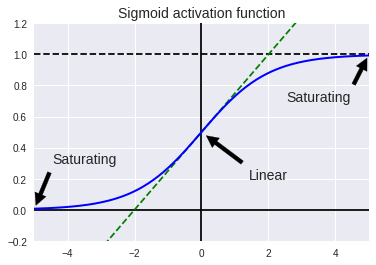

In [92]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

The logistic activation (sigmoid) function saturates at 0 or 1 when the inputs become large (negative or positive), with a derivative extremely close to 0. Thus when backpropagation kicks in, it has virtually no gradient to propagate back through the network, and what little gradient exists keeps getting diluted as backpropagation progresses down through the top layers, so there is really nothing left for the lower layers.

##Xavier and He Initialization
To propagate the signal properly, we need the variance of the outputs of each layer to be equal to the variance of its inputs, and we need the variance of the gradients to have equal variance before and after flowing through a layer in the reverse direction.

Note: the book uses **tensorflow.contrib.layers.fully_connected()** rather than **tf.layers.dense()** (which did not exist when this chapter was written). It is now preferable to use **tf.layers.dense()**, because anything in the contrib module may change or be deleted without notice. The **dense()** function is almost identical to the **fully_connected()** function. The main differences relevant to this chapter are:

* Several parameters are renamed: **scope** becomes **name**, **activation_fn** becomes **activation** (and similarly the **_fn** suffix is removed from other parameters such as **normalizer_fn)**, **weights_initializer** becomes **kernel_initializer**, etc.
* the default activation is now **None** rather than **tf.nn.relu**.
* it does not support **tensorflow.contrib.framework.arg_scope()** (introduced later in chapter 11).
* it does not support regularizer params (introduced later in chapter 11).

####Xavier initialization (when using the logistic activation function.. sigmoid)
* Normal distribution with mean 0 and standard deviation $\sigma=\sqrt{\frac{2}{n_{inputs}+n_{outputs}}}$,
* Uniform distribution between -r and +r, with $r=\sqrt{\frac{6}{n_{inputs}+n_{outputs}}}$

####He initialization (when using the ReLU and its variant activation functions)
* Normal distribution: $\sigma=\sqrt{2}\sqrt{\frac{2}{n_{inputs}+n_{outputs}}}$
* Uniform distribution: $r=\sqrt{2}\sqrt{\frac{6}{n_{inputs}+n_{outputs}}}$

####Initialziation strategy for hyperbolic tangent,
* Normal distribution: $\sigma=4\sqrt{\frac{2}{n_{inputs}+n_{outputs}}}$
* Uniform distribution: $r=4\sqrt{\frac{6}{n_{inputs}+n_{outputs}}}$

In [0]:
reset_graph()

n_inputs = 28* 28 #MNIST
n_hidden1 =300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')

In [0]:
he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, kernel_initializer=he_init, name='hidden1')

##Nonsaturating Activation Functions
The main problem for ReLU is that the gradient of the ReLU function is 0 when its input is negative and then the neurons are dead and they start to output 0.

To solve this problem, use variants of ReLU functions.

###Leaky ReLU
$LeakyReLU_{\alpha}(z) = max(\alpha z, z)$,

where $\alpha$ is a hyperparameter defining how much the function "leaks", which is the slope of the function for z < 0. Typically set to 0.01

###Randomized leaky ReLU (RReLU)
$\alpha$ is picked randomly in a given range during training, and it is fixed to an average value during testing.

###Parametric leaky ReLU (PReLU)
$\alpha$ is authorized to be learned.

In [0]:
def leaky_relu(z, alpha=0.01):
  return np.maximum(alpha*z, z)

[-5, 5, -0.5, 4.2]

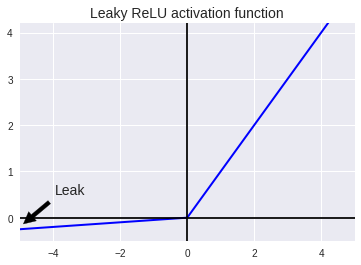

In [96]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

Implement Leaky ReLU in TensorFlow:

In [0]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')

In [0]:
def leaky_relu(z, name=None):
  return tf.maximum(0.01*z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name='hidden1')

Let's train a neural network on MNIST using the Leaky ReLU. First let's create the graph:

In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [0]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [0]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [0]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [0]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [0]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [0]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Load the data,

In [0]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [0]:
def shuffle_batch(X, y, batch_size):
  rnd_idx = np.random.permutation(len(X))
  n_batches = len(X) // batch_size
  
  for batch_idx in np.array_split(rnd_idx, n_batches):
    X_batch, y_batch = X[batch_idx], y[batch_idx]
    yield X_batch, y_batch

In [21]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
  init.run()
  for epoch in range(n_epochs):
    for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
      sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
    if epoch % 5 == 0:
      acc_batch = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
      acc_valid = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
      print(epoch, 'Batch accuracy:', acc_batch, 'Validation accuracy:', acc_valid)
      
  save_path = saver.save(sess, './my_model_final.ckpt')

0 Batch accuracy: 0.86 Validation accuracy: 0.86
5 Batch accuracy: 0.94 Validation accuracy: 0.94
10 Batch accuracy: 0.92 Validation accuracy: 0.92
15 Batch accuracy: 0.94 Validation accuracy: 0.94
20 Batch accuracy: 1.0 Validation accuracy: 1.0
25 Batch accuracy: 1.0 Validation accuracy: 1.0
30 Batch accuracy: 0.98 Validation accuracy: 0.98
35 Batch accuracy: 1.0 Validation accuracy: 1.0


###Exponential lineaar unit (ELU)
outperformed all the ReLU variants in their experiments: training time was reduced and the neural network performed better on the test set.

$ELU_{\alpha} = 
\left\{
        \begin{array}{ll}
            \alpha (\exp(z)-1) & \quad z < 0 \\
            z & \quad z \geq 0
        \end{array}
\right.$

In [0]:
def elu(z, alpha=1):
  return np.where(z<0, alpha*(np.exp(z)-1), z)

[-5, 5, -2.2, 3.2]

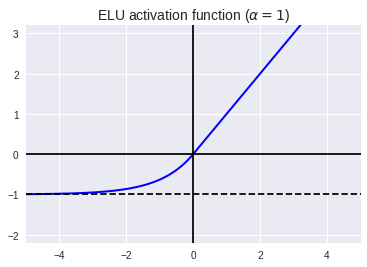

In [23]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [0]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
# change activation to elu
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")

Although your mileage will vary, in general ELU > leaky ReLU (and its variants) > ReLU > tanh > logistic. If you care a lot about runtime performance, then you may prefer leaky ReLUs over ELUs. If you don’t want to tweak yet another hyperparameter, you may just use the default α values suggested earlier (0.01 for the leaky ReLU, and 1 for ELU). If you have spare time and computing power, you can use cross-validation to evaluate other activation functions, in particular RReLU if your network is overfitting, or PReLU if you have a huge training set.

###SELU
This activation function was proposed in this great paper by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. During training, a neural network composed of a stack of dense layers using the SELU activation function will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets.

In [0]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * elu(z, alpha)

[-5, 5, -2.2, 3.2]

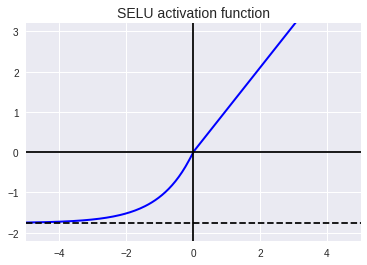

In [26]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

By default, the SELU hyperparameters (**scale** and **alpha**) are tuned in such a way that the mean remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 100 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [27]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100))
for layer in range(100):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1/100))
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=1)
    stds = np.std(Z, axis=1)
    if layer % 10 == 0:
        print("Layer {}: {:.2f} < mean < {:.2f}, {:.2f} < std deviation < {:.2f}".format(
            layer, means.min(), means.max(), stds.min(), stds.max()))

Layer 0: -0.26 < mean < 0.27, 0.74 < std deviation < 1.27
Layer 10: -0.24 < mean < 0.27, 0.74 < std deviation < 1.27
Layer 20: -0.17 < mean < 0.18, 0.74 < std deviation < 1.24
Layer 30: -0.27 < mean < 0.24, 0.78 < std deviation < 1.20
Layer 40: -0.38 < mean < 0.39, 0.74 < std deviation < 1.25
Layer 50: -0.27 < mean < 0.31, 0.73 < std deviation < 1.27
Layer 60: -0.26 < mean < 0.43, 0.74 < std deviation < 1.35
Layer 70: -0.19 < mean < 0.21, 0.75 < std deviation < 1.21
Layer 80: -0.18 < mean < 0.16, 0.72 < std deviation < 1.19
Layer 90: -0.19 < mean < 0.16, 0.75 < std deviation < 1.20


The **tf.nn.selu()** function was added in TensorFlow 1.4. For earlier versions, you can use the following implementation:

In [0]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z))

However, the SELU activation function cannot be used along with regular Dropout (this would cancel the SELU activation function's self-normalizing property). Fortunately, there is a Dropout variant called Alpha Dropout proposed in the same paper. It is available in **tf.contrib.nn.alpha_dropout()** since TF 1.4

Create a neural net for MNIST using the SELU activation function:

In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [30]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50

means = X_train.mean(axis=0, keepdims=True)
stds = X_train.std(axis=0, keepdims=True) + 1e-10
X_val_scaled = (X_valid - means) / stds

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_val_scaled, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final_selu.ckpt")

0 Batch accuracy: 0.88 Validation accuracy: 0.9232
5 Batch accuracy: 0.98 Validation accuracy: 0.9572
10 Batch accuracy: 1.0 Validation accuracy: 0.9662
15 Batch accuracy: 0.96 Validation accuracy: 0.9682
20 Batch accuracy: 1.0 Validation accuracy: 0.9692
25 Batch accuracy: 1.0 Validation accuracy: 0.9688
30 Batch accuracy: 1.0 Validation accuracy: 0.9692
35 Batch accuracy: 1.0 Validation accuracy: 0.97


##Batch Normalization
consists of adding an operation in the model just before the activation function of each layer, simply zero-centering and normalizing the inputs, then scaling and shifting the result using two new parameters per layer (one for scaling, the other for shifting).

*Batch Normalization algorithm
$
1. \mu_B = \frac{1}{m_B}\sum\limits_{i=1}^{m_B} x^{(i)} \\
2. \sigma_B = \frac{1}{m_B} \sum\limits_{i=1}^{m_B} (x^{(i)}-\mu_B)^2 \\
3. \hat{x}^{(i)} = \frac{x^{(i)}-\mu_B}{\sqrt{\mu_B^2+ \epsilon}} \\
4. z^{(i)}= \gamma \hat{x^{(i)}} + \beta
$
where
* $\mu_B$ is the empirical mean, evaluated over the whole mini-batch B.
* $\sigma_B$ is the empirical standard deviation, also evaluated over the whole mini-batch.
* $m_B$ is the number of instances in the mini-batch.
* $\hat{x^{(i)}}$ is the zero-centered and normalized input.
* $\gamma$ is the scaling parameter for the layer.
* $\epsilon$ is a tiny number to avoid division by zero (typically $10^{–3}$). This is called a *smoothing term*.
* $z^{(i)}$ is the output of the BN operation: it is a scaled and shifted version of the inputs.

At test time, there is no mini-batch to compute the empirical mean and standard deviation, so instead you simply use the whole training set’s mean and standard deviation. So, in total, four parameters are learned for each batch-normalized layer: $\gamma$(scale), $\beta$ (offset), $\mu$(mean), and $\sigma$(standard deviation).

Batch Normalization does, however, add some complexity to the model. The neural network makes slower predictions due to the extra computations required at each layer. So if you need predictions to be lightning-fast, you may want to check how well plain ELU + He initialization perform before playing with Batch Normalization.

###Implementing Batch Normalization with TensorFlow

In [0]:
reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name='training')
# This tells batch_normalization if it should use the current minibatch mean and std or
# the running averages that it keeps track of

hidden1 = tf.layers.dense(X, n_hidden1, name='hidden1')
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name='hidden2')
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name='outputs')
logits = tf.layers.batch_normalization(logits_before_bn, training=training, momentum=0.9)

To avoid repeating the same parameters over and over again, we can use Python's partial() function:

In [0]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')

In [0]:
from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization,
                              training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

Let's build a neural net for MNIST, using the ELU activation function and Batch Normalization at each layer:

In [0]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

In [0]:
with tf.name_scope('dnn'):
  he_init = tf.variance_scaling_initializer()
  
  my_batch_norm_layer = partial(tf.layers.batch_normalization,
                               training=training,
                               momentum=batch_norm_momentum)
  
  my_dense_layer = partial(tf.layers.dense,
                          kernel_initializer=he_init)
  
  hidden1 = my_dense_layer(X, n_hidden1, name='hidden1')
  bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
  hidden2 = my_dense_layer(hidden1, n_hidden2, name='hidden2')
  bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
  logits_before_bn = my_dense_layer(bn2, n_outputs, name='outputs')
  logits = my_batch_norm_layer(logits_before_bn)
  
with tf.name_scope('loss'):
  xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
  loss = tf.reduce_mean(xentropy, name='loss')
  
with tf.name_scope('train'):
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  training_op = optimizer.minimize(loss)
  
with tf.name_scope('eval'):
  correct = tf.nn.in_top_k(logits, y, 1)
  accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
  
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [43]:
n_epochs = 20
batch_size = 200

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
  init.run()
  
  for epoch in range(n_epochs):
    for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
      sess.run([training_op, extra_update_ops],
              feed_dict={training:True, X:X_batch, y:y_batch})
    accuracy_val = accuracy.eval(feed_dict={X:X_valid, y:y_valid})
    print(epoch, 'Validation accuracy:', accuracy_val)
      
  save_path = saver.save(sess, './my_model_final.ckpt')

0 Validation accuracy: 0.883
1 Validation accuracy: 0.9112
2 Validation accuracy: 0.9212
3 Validation accuracy: 0.9284
4 Validation accuracy: 0.9358
5 Validation accuracy: 0.9426
6 Validation accuracy: 0.9494
7 Validation accuracy: 0.9508
8 Validation accuracy: 0.9546
9 Validation accuracy: 0.9576
10 Validation accuracy: 0.9596
11 Validation accuracy: 0.9622
12 Validation accuracy: 0.9648
13 Validation accuracy: 0.966
14 Validation accuracy: 0.9682
15 Validation accuracy: 0.9672
16 Validation accuracy: 0.9682
17 Validation accuracy: 0.9704
18 Validation accuracy: 0.9694
19 Validation accuracy: 0.9684


Note that you could also make the training operation depend on the update operations:

In [0]:
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        training_op = optimizer.minimize(loss)

This way, you would just have to evaluate the training_op during training, TensorFlow would automatically run the update operations as well:

In [0]:
sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})

One more thing: notice that the list of trainable variables is shorter than the list of all global variables. This is because the moving averages are non-trainable variables. If you want to reuse a pretrained neural network (see below), you must not forget these non-trainable variables.

In [44]:
[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0']

In [45]:
[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

##Gradient Clipping
A popular technique to lessen the exploding gradients problem is to simply clip the gradients during backpropagation so that they never exceed some threshold (this is mostly useful for recurrent neural networks.)

In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")


In [0]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [0]:
learning_rate = 0.01

Now we apply gradient clipping. For this, we need to get the gradients, use the clip_by_value() function to clip them, then apply them:

In [0]:
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var) for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

The rest is the same.....

In [50]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.2876
1 Validation accuracy: 0.7934
2 Validation accuracy: 0.8798
3 Validation accuracy: 0.9064
4 Validation accuracy: 0.9162
5 Validation accuracy: 0.9222
6 Validation accuracy: 0.9292
7 Validation accuracy: 0.9358
8 Validation accuracy: 0.9382
9 Validation accuracy: 0.9414
10 Validation accuracy: 0.9458
11 Validation accuracy: 0.9472
12 Validation accuracy: 0.9476
13 Validation accuracy: 0.9536
14 Validation accuracy: 0.9566
15 Validation accuracy: 0.9566
16 Validation accuracy: 0.9576
17 Validation accuracy: 0.9588
18 Validation accuracy: 0.9622
19 Validation accuracy: 0.9614


#Reusing Pretrained Layers
Transfer learning: It is generally not a good idea to train a very large DNN from scratch: instead, you should always try to find an existing neural network that accomplishes a similar task to the one you are trying to tackle, then just reuse the lower layers of this network.

If the input pictures of your new task don’t have the same size as the ones used in the original task, you will have to add a preprocessing step to resize them to the size expected by the original model. More generally, transfer learning will work only well if the
inputs have similar low-level features.

##Reusing a TensorFlow Model
First you need to load the graph's structure. The **import_meta_graph()** function does just that, loading the graph's operations into the default graph, and returning a **Saver** that you can then use to restore the model's state. Note that by default, a **Saver** saves the structure of the graph into a **.meta** file, so that's the file you should load:

In [0]:
reset_graph()

In [0]:
saver = tf.train.import_meta_graph('./my_model_final.ckpt.meta')

Next you need to get a handle on all the operations you will need for training. If you don't know the graph's structure, you can list all the operations

In [53]:
for op in tf.get_default_graph().get_operations():
  print(op.name)

X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read
hidden2/bias/Initializer/zeros
hidden2/bias
hidden2/bias/Assign
hidden2/bias/read
dn

That's.... a lot..

It's much easier to use TensorBoard to visualize the graph. The following hack will allow you to visualize the graph within Jupyter (if it does not work with your browser, you will need to use a FileWriter to save the graph and then visualize it in TensorBoard):

In [0]:
from tensorflow_graph_in_jupyter import show_graph
show_graph(tf.get_default_graph())

Once you know which operations you need, you can get a handle on them using the graph's **get_operation_by_name()** or **get_tensor_by_name()** methods:

In [0]:
X = tf.get_default_graph().get_tensor_by_name('X:0')
y = tf.get_default_graph().get_tensor_by_name('y:0')

accuracy = tf.get_default_graph().get_tensor_by_name('eval/accuracy:0')

training_op = tf.get_default_graph().get_operation_by_name('GradientDescent')

If you are the author of the original model, you could make things easier for people who will reuse your model by giving operations very clear names and documenting them. 

Another approach is to create a collection containing all the important operations that people will want to get a handle on:

In [0]:
for op in (X, y, accuracy, training_op):
  tf.add_to_collection('my_important_ops', op)

In this way people who reuse your model will be able to simply write:

In [0]:
X, y, accuracy, training_op = tf.get_collection('my_important_ops')

start a session, restore the model's state and continue training on your data:

In [60]:
with tf.Session() as sess:
  saver.restore(sess, './my_model_final.ckpt')
  
  for epoch in range(n_epochs):
      for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
          sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
      accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
      print(epoch, "Validation accuracy:", accuracy_val)

  save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9642
1 Validation accuracy: 0.9632
2 Validation accuracy: 0.9654
3 Validation accuracy: 0.9652
4 Validation accuracy: 0.9642
5 Validation accuracy: 0.965
6 Validation accuracy: 0.9684
7 Validation accuracy: 0.9686
8 Validation accuracy: 0.9686
9 Validation accuracy: 0.9688
10 Validation accuracy: 0.9702
11 Validation accuracy: 0.9716
12 Validation accuracy: 0.967
13 Validation accuracy: 0.9702
14 Validation accuracy: 0.9714
15 Validation accuracy: 0.9722
16 Validation accuracy: 0.9722
17 Validation accuracy: 0.971
18 Validation accuracy: 0.9712
19 Validation accuracy: 0.9716


Alternatively, if you have access to the Python code that built the original graph, you can use it instead of **import_meta_graph()**:

In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [62]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9642
1 Validation accuracy: 0.9632
2 Validation accuracy: 0.9654
3 Validation accuracy: 0.9652
4 Validation accuracy: 0.9642
5 Validation accuracy: 0.965
6 Validation accuracy: 0.9684
7 Validation accuracy: 0.9686
8 Validation accuracy: 0.9686
9 Validation accuracy: 0.9688
10 Validation accuracy: 0.9702
11 Validation accuracy: 0.9716
12 Validation accuracy: 0.967
13 Validation accuracy: 0.9702
14 Validation accuracy: 0.9714
15 Validation accuracy: 0.9722
16 Validation accuracy: 0.9722
17 Validation accuracy: 0.971
18 Validation accuracy: 0.9712
19 Validation accuracy: 0.9716


In general you will want to reuse only the lower layers. If you are using **import_meta_graph()** it will load the whole graph, but you can simply ignore the parts you do not need. In this example, we *add a new 4th hidden layer on top of the pretrained 3rd layer* (ignoring the old 4th hidden layer). We also build a *new output layer*, *the loss for this new output*, and a *new optimizer to minimize it*. We also need another saver to save the whole graph (containing both the entire old graph plus the new operations), and an initialization operation to initialize all the new variables:

In [0]:
reset_graph()

n_hidden4 = 20  # new layer
n_outputs = 10  # new layer

In [0]:
saver = tf.train.import_meta_graph('./my_model_final.ckpt.meta')

In [0]:
# reuse the variables
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 =tf.get_default_graph().get_tensor_by_name('dnn/hidden2/Relu:0')

new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name='new_hidden4')
new_logits = tf.layers.dense(new_hidden4, n_outputs, name='new_outputs')

In [0]:
with tf.name_scope('new_loss'):
  xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
  loss = tf.reduce_mean(xentropy, name='loss')
  
with tf.name_scope('new_eval'):
  correct = tf.nn.in_top_k(new_logits, y, 1)
  accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')
  
with tf.name_scope('new_train'):
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  training_op = optimizer.minimize(loss)
  
init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

And we can train this new model:

In [67]:
with tf.Session() as sess:
  init.run()
  saver.restore(sess, './my_model_final.ckpt')
  
  for epoch in range(n_epochs):
    for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
      sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
    accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
    print(epoch, 'Validation accuracy:', accuracy_val)
  
  save_path = new_saver.save(sess, './my_new_model_final.ckpt')

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.8888
1 Validation accuracy: 0.919
2 Validation accuracy: 0.9318
3 Validation accuracy: 0.939
4 Validation accuracy: 0.9438
5 Validation accuracy: 0.9446
6 Validation accuracy: 0.9482
7 Validation accuracy: 0.9516
8 Validation accuracy: 0.9532
9 Validation accuracy: 0.9534
10 Validation accuracy: 0.9568
11 Validation accuracy: 0.9572
12 Validation accuracy: 0.9578
13 Validation accuracy: 0.9594
14 Validation accuracy: 0.9616
15 Validation accuracy: 0.9618
16 Validation accuracy: 0.9624
17 Validation accuracy: 0.9628
18 Validation accuracy: 0.9638
19 Validation accuracy: 0.9644


If you have access to the Python code that built the original graph, you can just reuse the parts you need and drop the rest:

In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

However, you must create one Saver to restore the pretrained model (giving it the list of variables to restore, or else it will complain that the graphs don't match), and another Saver to save the new model, once it is trained:

In [70]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val) 

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9028
1 Validation accuracy: 0.9336
2 Validation accuracy: 0.9432
3 Validation accuracy: 0.9472
4 Validation accuracy: 0.952
5 Validation accuracy: 0.9536
6 Validation accuracy: 0.9556
7 Validation accuracy: 0.959
8 Validation accuracy: 0.9588
9 Validation accuracy: 0.9604
10 Validation accuracy: 0.9624
11 Validation accuracy: 0.9618
12 Validation accuracy: 0.9642
13 Validation accuracy: 0.9662
14 Validation accuracy: 0.9664
15 Validation accuracy: 0.9658
16 Validation accuracy: 0.9672
17 Validation accuracy: 0.9672
18 Validation accuracy: 0.9682
19 Validation accuracy: 0.9674


##Reusing Models from Other Frameworks
In this example, for each variable we want to reuse, we find its initializer's assignment operation, and we get its second input, which corresponds to the initialization value. When we run the initializer, we replace the initialization values with the ones we want, using a **feed_dict**:

In [0]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

In [72]:
original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the assignment nodes for the hidden1 variables
graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict={init_kernel: original_w, init_bias: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))

[[ 61.  83. 105.]]


Another approach would be to create dedicated assignment nodes and dedicated placeholders. This is more verbose and less efficient, but more explicit:

In [73]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the variables of layer hidden1
with tf.variable_scope("", default_name="", reuse=True):  # root scope
    hidden1_weights = tf.get_variable("hidden1/kernel")
    hidden1_biases = tf.get_variable("hidden1/bias")

# Create dedicated placeholders and assignment nodes
original_weights = tf.placeholder(tf.float32, shape=(n_inputs, n_hidden1))
original_biases = tf.placeholder(tf.float32, shape=n_hidden1)
assign_hidden1_weights = tf.assign(hidden1_weights, original_weights)
assign_hidden1_biases = tf.assign(hidden1_biases, original_biases)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    sess.run(assign_hidden1_weights, feed_dict={original_weights: original_w})
    sess.run(assign_hidden1_biases, feed_dict={original_biases: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))

[[ 61.  83. 105.]]


Note that we could also get a handle on the variables using **get_collection()** and specifying the **scope**:

In [74]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden1")

[<tf.Variable 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(3,) dtype=float32_ref>]

Or we could use the graph's **get_tensor_by_name()** method:

In [75]:
tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")

<tf.Tensor 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>

In [76]:
tf.get_default_graph().get_tensor_by_name("hidden1/bias:0")

<tf.Tensor 'hidden1/bias:0' shape=(3,) dtype=float32_ref>

##Freezing the Lower Layers
It is likely that the lower layers of the first DNN have learned to detect low-level features in pictures that will be useful across both image classification tasks, so you can just reuse these layers as they are.

It is generally a good idea to “freeze” their weights when training the new DNN: if the lower-layer weights are fixed, then the higher-
layer weights will be easier to train.

1st DNN,

In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [0]:
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate) 
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                   scope="hidden[34]|outputs")
    training_op = optimizer.minimize(loss, var_list=train_vars)

In [0]:
init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [80]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.8974
1 Validation accuracy: 0.9308
2 Validation accuracy: 0.9402
3 Validation accuracy: 0.9448
4 Validation accuracy: 0.9478
5 Validation accuracy: 0.951
6 Validation accuracy: 0.951
7 Validation accuracy: 0.9534
8 Validation accuracy: 0.9552
9 Validation accuracy: 0.9566
10 Validation accuracy: 0.9558
11 Validation accuracy: 0.9568
12 Validation accuracy: 0.9572
13 Validation accuracy: 0.958
14 Validation accuracy: 0.9588
15 Validation accuracy: 0.958
16 Validation accuracy: 0.9576
17 Validation accuracy: 0.9602
18 Validation accuracy: 0.9592
19 Validation accuracy: 0.9602


2nd DNN, with frozen layers

In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [0]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

In [0]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [84]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.902
1 Validation accuracy: 0.9304
2 Validation accuracy: 0.9436
3 Validation accuracy: 0.948
4 Validation accuracy: 0.9514
5 Validation accuracy: 0.9524
6 Validation accuracy: 0.9522
7 Validation accuracy: 0.9556
8 Validation accuracy: 0.9554
9 Validation accuracy: 0.9562
10 Validation accuracy: 0.9568
11 Validation accuracy: 0.9552
12 Validation accuracy: 0.9574
13 Validation accuracy: 0.9578
14 Validation accuracy: 0.958
15 Validation accuracy: 0.957
16 Validation accuracy: 0.9564
17 Validation accuracy: 0.9574
18 Validation accuracy: 0.9594
19 Validation accuracy: 0.9578


##Caching the Frozen Layers
Since the frozen layers won’t change, it is possible to cache the output of the topmost frozen layer for each training instance.

Since training goes through the whole dataset many times, this will give you a huge speed boost as you will only need to go through
the frozen layers once per training instance (instead of once per epoch).

For example,
you could first run the whole training set through the lower layers,

In [0]:
hidden2_outputs = sess.run(hidden2, feed_dict={X: X_train})

Then during training, instead of building batches of training instances, you would build batches of outputs from hidden layer 2 and feed them to the training operation:

In [0]:
n_epochs = 100
n_batches = 500
for epoch in range(n_epochs):
shuffled_idx = rnd.permutation(len(hidden2_outputs))
hidden2_batches = np.array_split(hidden2_outputs[shuffled_idx], n_batches)
y_batches = np.array_split(y_train[shuffled_idx], n_batches)
for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
sess.run(training_op, feed_dict={hidden2: hidden2_batch, y: y_batch})

To see the complete code,


In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen & cached
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [0]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                              scope='hidden[123]')
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [114]:
n_batches = len(X_train) // batch_size

with tf.Session() as sess:
  init.run()
  restore_saver.restore(sess, './my_model_final.ckpt')
  
  h2_cache = sess.run(hidden2, feed_dict={X: X_train})
  h2_cache_valid = sess.run(hidden2, feed_dict={X: X_valid})
  
  for epoch in range(n_epochs):
    shuffled_idx = np.random.permutation(len(X_train))
    hidden2_batches = np.array_split(h2_cache[shuffled_idx], n_batches)
    y_batches = np.array_split(y_train[shuffled_idx], n_batches)
    
    for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
      sess.run(training_op, feed_dict={hidden2: hidden2_batch, y:y_batch})
      
    accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_valid, y:y_valid})
    print(epoch, 'Validation accuracy:', accuracy_val)
    
  save_path = saver.save(sess, './my_new_model_final.ckpt')

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.902
1 Validation accuracy: 0.9304
2 Validation accuracy: 0.9436
3 Validation accuracy: 0.948
4 Validation accuracy: 0.9514
5 Validation accuracy: 0.9524
6 Validation accuracy: 0.9522
7 Validation accuracy: 0.9556
8 Validation accuracy: 0.9554
9 Validation accuracy: 0.9562
10 Validation accuracy: 0.9568
11 Validation accuracy: 0.9552
12 Validation accuracy: 0.9574
13 Validation accuracy: 0.9578
14 Validation accuracy: 0.958
15 Validation accuracy: 0.957
16 Validation accuracy: 0.9564
17 Validation accuracy: 0.9574
18 Validation accuracy: 0.9594
19 Validation accuracy: 0.9578


#Faster Optimizers
The conclusion of this section is that you should almost always use Adam optimization.

##Momentum optimization
1. $m \leftarrow \beta m + \eta \nabla_{\theta} J(\theta)$
2. $\theta \leftarrow \theta - m$

where $\beta$ is the *momentum*, be set between 0 (high friction) and 1 (no friction). A typical momentum value is 0.9.

In deep neural networks that don’t use Batch Normalization, the upper layers will often end up having inputs with very different scales, so using Momentum optimization helps a lot. It can also help roll past local optima.

Due to the momentum, the optimizer may overshoot a bit, then come back, overshoot again, and oscillate like this many times
before stabilizing at the minimum. This is one of the reasons why it is good to have a bit of friction in the system: it gets rid of these
oscillations and thus speeds up convergence.

The one drawback of Momentum optimization is that it adds yet another hyperparameter to tune. However, the momentum value of 0.9 usually works well in practice and almost always goes faster than Gradient Descent.

In [0]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)

##Nesterov Accelerated Gradient
measures the gradient of the cost function not at the local position but slightly ahead in the direction of the momentum.

1. $m \leftarrow \beta m + \eta \nabla_{\theta} J(\theta + \beta m)$
2. $\theta \leftarrow \theta - m$

In [0]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9, use_nesterov=True)

##AdaGrad
scales down the gradient vector along the steepest dimensions

1. $s \leftarrow s + \nabla_{\theta}J(\theta) \otimes \nabla_{\theta}J(\theta)$
2. $\theta \leftarrow \theta - \eta\nabla_{\theta}J(\theta)\oslash\sqrt{s+\epsilon}$

where,

step 1 accumulates the square of the gradients into the vector $s$, ($\otimes$ represents the element-wise multiplication, which is equivalent to $s_i \leftarrow s_i+(\frac{\partial}{\partial\theta_i}J(\theta))^2 $ for each element $s_i$ of the vector $s$)

step2 scales the gradient vector down by a factor of $\sqrt{s+\epsilon}$, ($\oslash$ represents the element-wise divsion). $\epsilon$ is a smoothing term to avoid division by zero.

this algorithm decays the learning rate, but it does so faster for steep dimensions than for dimensions with gentler slopes, which is called *adaptive learning reate*

AdaGrad often performs well for simple quadratic problems, but unfortunately it
often stops too early when training neural networks. The learning rate gets scaled
down so much that the algorithm ends up stopping entirely before reaching the
global optimum.

In [0]:
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

##RMSProp
1. $s\leftarrow\beta s + (1-\beta)\nabla_{\theta}J(\theta)\otimes\nabla_{\theta}J(\theta)$
2. $\theta \leftarrow \theta - \eta\nabla_{\theta}J(\theta)\oslash\sqrt{s+\epsilon}$

Although *AdaGrad* slows down a bit too fast and ends up never converging to the global optimum, the *RMSProp* algorithm fixes this by accumulating only the gradi‐ ents from the most recent iterations

In [0]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,
                                      momentum=0.9, decay=0.9, epsilon=1e-10)

##Adam Optimization
which stands for adaptive moment estimation,

1. $m\leftarrow\beta_1 m+(1-\beta_1)\nabla_{\theta}J(\theta)$
2. $s\leftarrow\beta_2 s +(1-\beta_2)\nabla_{\theta}J(\theta)\otimes\nabla_{\theta}J(\theta)$
3. $m\leftarrow\frac{m}{1-\beta_1^T}$
4. $s\leftarrow\frac{s}{1-\beta_2^T}$
5. $\theta\leftarrow\theta-\eta m\oslash\sqrt{s+\epsilon}$

where $T$ represents the iteration number (starting at 1)

Adam’s close similarity to both Momentum optimization and RMSProp.

The momentum decay hyperparameter $\beta_1$ is typically initialized to 0.9, while the scaling decay hyperparameter $\beta_2$ is often initialized to 0.999.

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

use the default value η = 0.001, making Adam even easier to use than Gradient Descent.

All the optimization techniques discussed so far only rely on the *first-order partial derivatives (Jacobians)*.

##Learning Rate Scheduling

In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

Implementing a learning schedule with TensorFlow

In [0]:
with tf.name_scope("train"):       # not shown in the book
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name="global_step")
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)

In [0]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [118]:
n_epochs = 5
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.954
1 Validation accuracy: 0.9724
2 Validation accuracy: 0.973
3 Validation accuracy: 0.9788
4 Validation accuracy: 0.9816


#Avoiding Overfitting Through Regularization
##Early Stopping
just interrupts training when its performance on the validation set starts
dropping.

implementing this with TensorFlow is to evaluate the model on a validation set at regular intervals (e.g., every 50 steps), and save a “winner” snapshot if it outperforms previous “winner” snapshots.

##$\ell_1$ and $\ell_2$ Regularizations
One way to do this using TensorFlow is to simply add the appropriate regularization terms to your cost function.

Let's implement $\ell_1$ regularization manually. First, we create the model, as usual (with just one hidden layer this time, for simplicity):

In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope('dnn'):
  hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name='hidden1')
  logits = tf.layers.dense(hidden1, n_outputs, name='outputs')

Next, we get a handle on the layer weights, and we compute the total loss, which is equal to the sum of the usual cross entropy loss and the $\ell_1$ loss (i.e., the absolute values of the weights):

In [0]:
W1 = tf.get_default_graph().get_tensor_by_name('hidden1/kernel:0')
W2 = tf.get_default_graph().get_tensor_by_name('outputs/kernel:0')

scale = 0.001 # L1 regularization hyperparameter

with tf.name_scope('loss'):
  xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
  base_loss = tf.reduce_mean(xentropy, name='avg_xentropy')
  reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
  loss = tf.add(base_loss, scale*reg_losses, name='loss')

The rest is just as usual:

In [0]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [122]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.831
1 Validation accuracy: 0.871
2 Validation accuracy: 0.8838
3 Validation accuracy: 0.8934
4 Validation accuracy: 0.8966
5 Validation accuracy: 0.8988
6 Validation accuracy: 0.9016
7 Validation accuracy: 0.9044
8 Validation accuracy: 0.9058
9 Validation accuracy: 0.906
10 Validation accuracy: 0.9068
11 Validation accuracy: 0.9054
12 Validation accuracy: 0.907
13 Validation accuracy: 0.9084
14 Validation accuracy: 0.9088
15 Validation accuracy: 0.9064
16 Validation accuracy: 0.9066
17 Validation accuracy: 0.9066
18 Validation accuracy: 0.9066
19 Validation accuracy: 0.9052


Alternatively, we can pass a regularization function to the **tf.layers.dense() function**, which will use it to create operations that will compute the regularization loss, and it adds these operations to the collection of regularization losses. The beginning is the same as above:

In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

Next, we will use Python's **partial()** function to avoid repeating the same arguments over and over again. Note that we set the kernel_regularizer argument:

In [0]:
scale = 0.001

In [0]:
my_dense_layer = partial(tf.layers.dense,
                        activation=tf.nn.relu,
                        kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope('dnn'):
  hidden1 = my_dense_layer(X, n_hidden1, name='hidden1')
  hidden2 = my_dense_layer(hidden1, n_hidden2, name='hidden2')
  logits = my_dense_layer(hidden2, n_outputs, activation=None, name='outputs')

Next we must add the regularization losses to the base loss:

In [0]:
with tf.name_scope('loss'):
  xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
  base_loss = tf.reduce_mean(xentropy, name='avg_xentropy')
  reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
  loss = tf.add_n([base_loss] + reg_losses, name='loss')

the rest is the same as usual:

In [0]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [128]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.8274
1 Validation accuracy: 0.8766
2 Validation accuracy: 0.8952
3 Validation accuracy: 0.9016
4 Validation accuracy: 0.9082
5 Validation accuracy: 0.9096
6 Validation accuracy: 0.9126
7 Validation accuracy: 0.9154
8 Validation accuracy: 0.9178
9 Validation accuracy: 0.919
10 Validation accuracy: 0.92
11 Validation accuracy: 0.9224
12 Validation accuracy: 0.9212
13 Validation accuracy: 0.9228
14 Validation accuracy: 0.9224
15 Validation accuracy: 0.9216
16 Validation accuracy: 0.9218
17 Validation accuracy: 0.9228
18 Validation accuracy: 0.9216
19 Validation accuracy: 0.9214


##Dropout
at every training step, every neuron (including the input neurons but excluding the output neurons) has a probability $p$ of being tem‐
porarily “dropped out,” meaning it will be entirely ignored during this training step, but it may be active during the next step.

The hyperparameter $p$ is called the dropout rate, and it is typically set to 50%. After training, neurons don’t get dropped anymore.

In [0]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [0]:
# A placeholder op that passes through input when its output is not fed.
training = tf.placeholder_with_default(False, shape=(), name='training')

dropout_rate = 0.5 # == 1 - keep_probability
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope('dnn'):
  hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu, name='hidden1')
  hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
  hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu, name='hidden2')
  hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
  logits = tf.layers.dense(hidden2_drop, n_outputs, name='outputs')

In [0]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [132]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.9254
1 Validation accuracy: 0.9452
2 Validation accuracy: 0.9492
3 Validation accuracy: 0.9566
4 Validation accuracy: 0.9618
5 Validation accuracy: 0.9602
6 Validation accuracy: 0.96
7 Validation accuracy: 0.9674
8 Validation accuracy: 0.9688
9 Validation accuracy: 0.9702
10 Validation accuracy: 0.9678
11 Validation accuracy: 0.9684
12 Validation accuracy: 0.9714
13 Validation accuracy: 0.9708
14 Validation accuracy: 0.971
15 Validation accuracy: 0.971
16 Validation accuracy: 0.973
17 Validation accuracy: 0.9716
18 Validation accuracy: 0.9732
19 Validation accuracy: 0.974


Just like you did earlier for Batch Normalization, you need to set **training** to **True** when training, and to **False** when testing.

If you observe that the model is overfitting, you can increase the dropout rate (i.e., reduce the keep_prob hyperparameter). Conversely, you should try decreasing the dropout rate (i.e., increasing keep_prob) if the model underfits the training set.

##Max-Norm Regularization
for each neuron, it constrains the weights $w$ of the incoming connections such that $|| w||_2 ≤ r$, where $r$ is the max-norm hyperparameter and $||\cdot||_2$ is the $\ell_2$ norm.

We typically implement this constraint by computing  $|| w||_2 $ after each training step and clipping $w$ if needed $(w\leftarrow w\frac{r}{||w||_2}$)

Let's go back to a plain and simple neural net for MNIST with just 2 hidden layers:

In [0]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

Next, let's get a handle on the first hidden layer's weight and create an operation that will compute the clipped weights using the **clip_by_norm()** function. Then we create an assignment operation to assign the clipped weights to the weights variable:

In [0]:
threshold = 1.0
weights = tf.get_default_graph().get_tensor_by_name('hidden1/kernel:0')
clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)
clip_weights = tf.assign(weights, clipped_weights)

We can do this as well for the second hidden layer:

In [0]:
weights2 = tf.get_default_graph().get_tensor_by_name("hidden2/kernel:0")
clipped_weights2 = tf.clip_by_norm(weights2, clip_norm=threshold, axes=1)
clip_weights2 = tf.assign(weights2, clipped_weights2)

Let's add an initializer and a saver:

In [0]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

And now we can train the model. It's pretty much as usual, except that right after running the **training_op**, we run the **clip_weights** and **clip_weights2** operations:

In [0]:
n_epochs = 20
batch_size = 50

In [148]:
with tf.Session() as sess:
  init.run()
  for epoch in range(n_epochs):
    for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
      sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
      clip_weights.eval() # apply here
      clip_weights2.eval() # apply here
    acc_valid = accuracy.eval(feed_dict={X:X_valid, y:y_valid})
    print(epoch, 'Validation accuracy:', acc_valid)
    
  save_path = saver.save(sess, './my_model_final.ckpt')

0 Validation accuracy: 0.9568
1 Validation accuracy: 0.9696
2 Validation accuracy: 0.9716
3 Validation accuracy: 0.9772
4 Validation accuracy: 0.9772
5 Validation accuracy: 0.9774
6 Validation accuracy: 0.9822
7 Validation accuracy: 0.981
8 Validation accuracy: 0.98
9 Validation accuracy: 0.9824
10 Validation accuracy: 0.9822
11 Validation accuracy: 0.9852
12 Validation accuracy: 0.9824
13 Validation accuracy: 0.984
14 Validation accuracy: 0.9842
15 Validation accuracy: 0.9842
16 Validation accuracy: 0.984
17 Validation accuracy: 0.9834
18 Validation accuracy: 0.9842
19 Validation accuracy: 0.9844


The implementation above is straightforward and it works fine, but it is a bit messy. A better approach is to define a **max_norm_regularizer()** function:

In [0]:
def max_norm_regularizer(threshold, axes=1, name='max_norm', collection='max_norm'):
  def max_norm(weights):
    clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
    clip_weights = tf.assign(weights, clipped, name=name)
    tf.add_to_collection(collection, clip_weights)
    return None # there is no regularization loss term
  return max_norm

Then you can call this function to get a max norm regularizer (with the threshold you want). When you create a hidden layer, you can pass this regularizer to the **kernel_regularizer** argument:

In [0]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [0]:
max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [0]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Training is as usual, except you must run the weights clipping operations after each training operation:

In [0]:
n_epochs = 20
batch_size = 50

In [155]:
clip_all_weights = tf.get_collection('max_norm')

with tf.Session() as sess:
  init.run()
  for epoch in range(n_epochs):
    for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
      sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
      sess.run(clip_all_weights)
    acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
    print(epoch, "Validation accuracy:", acc_valid) 

  save_path = saver.save(sess, "./my_model_final.ckpt") 

0 Validation accuracy: 0.9558
1 Validation accuracy: 0.9684
2 Validation accuracy: 0.9742
3 Validation accuracy: 0.9748
4 Validation accuracy: 0.977
5 Validation accuracy: 0.9802
6 Validation accuracy: 0.9782
7 Validation accuracy: 0.9798
8 Validation accuracy: 0.9818
9 Validation accuracy: 0.9816
10 Validation accuracy: 0.983
11 Validation accuracy: 0.982
12 Validation accuracy: 0.9832
13 Validation accuracy: 0.983
14 Validation accuracy: 0.9838
15 Validation accuracy: 0.9838
16 Validation accuracy: 0.9838
17 Validation accuracy: 0.9836
18 Validation accuracy: 0.9838
19 Validation accuracy: 0.9834
